In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap
from jax import jit, lax, grad
import matplotlib.pyplot as plt
import cmocean as cmo
import importlib
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from jax.config import config
config.update("jax_enable_x64", True)

import warnings
warnings.filterwarnings("always")

from bbmm.utils import test_modules
import bbmm.utils.preconditioner as precond
import bbmm.utils.conjugate_gradient as cg
import bbmm.utils.calc_logdet as calc_logdet
importlib.reload(test_modules)

import linear_operator
import torch
from linear_operator.operators import (
    AddedDiagLinearOperator,
    DenseLinearOperator,
    DiagLinearOperator,
    LinearOperator,
)

/home/ogawa_kenta/research/M2/bbmm_implementation/duplication_of_bbmm/bbmm/operators/psd_sum_linear_operator.py:35: DeprecationWarning: invalid escape sequence \s
  """
/home/ogawa_kenta/.conda/envs/mytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
_K = np.load("tests/data/cov_sinusoidal_direct.npy")
delta_y = np.load("tests/data/delta_y_sinusoidal_direct.npy")
seed=0
noise=1e-06
N = len(_K)
K = _K + jnp.eye(N) * noise
test_modules.check_cond(K)

5.75e+08


DeviceArray(5.74882553e+08, dtype=float64)

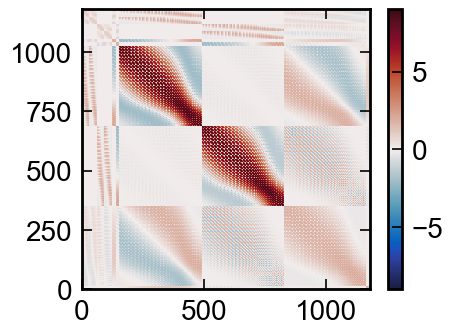

In [3]:
fig, ax = plt.subplots(figsize=(5, 4))
mappable = ax.pcolormesh(np.flipud(K), vmin=-np.max(K), vmax=np.max(K), cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [4]:
def loss_linalg(K, delta_y, return_linear_solve=False, return_logdet=False, return_loss=True):
    n = len(delta_y)
    L = jnp.linalg.cholesky(K)
    Kinvy = jnp.linalg.solve(L.T, jnp.linalg.solve(L, delta_y))
    v = jnp.linalg.solve(L, delta_y)
    logdet = jnp.sum(jnp.log(jnp.diag(L)))*2
    loss = 0.5 * (
        jnp.dot(v, v)
        + logdet
        + n * jnp.log(2.0 * jnp.pi)
    ) / len(K)
    return_list = []
    if return_loss: return_list.append(loss)
    if return_linear_solve: return_list.append(Kinvy)
    if return_logdet: return_list.append(logdet)
    return return_list

def loss_torch(_K, delta_y, n_tridiag, return_linear_solve=False, return_logdet=False, return_loss=True, seed=0):
    n = len(delta_y)
    
    K_torch = torch.from_numpy(np.array(_K))
    K_linear_op = linear_operator.to_linear_operator(K_torch)
    diag_tensor = torch.ones(N, dtype=torch.float64) * noise
    diag_linear_op = DiagLinearOperator(diag_tensor)
    added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)
    
    preconditioner_torch, precond_lt_torch, precond_logdet_torch = added_diag._preconditioner()

    zs = jax.random.normal(jax.random.PRNGKey(seed), (len(delta_y), n_tridiag))
    if preconditioner_torch:
        zs = precond_lt_torch.zero_mean_mvn_samples(n_tridiag).numpy().T
    # else:
    #     zs = jax.random.normal(jax.random.PRNGKey(seed), (len(delta_y), n_tridiag))
    zs_norm = jnp.linalg.norm(zs, axis=0)
    zs = zs / zs_norm
    rhs = jnp.concatenate([zs, delta_y.reshape(-1, 1)], axis=1)
    rhs_torch = torch.from_numpy(np.array(rhs))

    Kinvy_torch, t_mat_torch = added_diag._solve(rhs_torch, preconditioner=preconditioner_torch, num_tridiag=n_tridiag)
    eval_torch, evec_torch = linear_operator.utils.lanczos.lanczos_tridiag_to_diag(t_mat_torch)
    slq = linear_operator.utils.stochastic_lq.StochasticLQ()
    (logdet_term,) = slq.to_dense(added_diag.matrix_shape, eval_torch, evec_torch,  [lambda x: x.log()])
    if precond_logdet_torch:
        logdet_term += precond_logdet_torch
    loss = 0.5 * (delta_y@Kinvy_torch[:, -1].numpy() + logdet_term.numpy() + n * jnp.log(2.0 * jnp.pi)) / len(K)

    return_list = []
    if return_loss: return_list.append(loss)
    if return_linear_solve: return_list.append(Kinvy_torch)
    if return_logdet: return_list.append(logdet_term)
    return return_list

def loss_torch_inv_quad(_K, delta_y, n_tridiag, return_linear_solve=False, return_logdet=False, return_loss=True, seed=0):
    n = len(delta_y)
    K_torch = torch.from_numpy(np.array(_K))
    K_linear_op = linear_operator.to_linear_operator(K_torch)
    diag_tensor = torch.ones(N, dtype=torch.float64) * noise
    diag_linear_op = DiagLinearOperator(diag_tensor)
    added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

    rhs_torch = torch.from_numpy(np.array(delta_y.reshape(-1, 1)))
    torch.manual_seed(seed)
    inv_quad, logdet_torch = added_diag.inv_quad_logdet(inv_quad_rhs=rhs_torch, logdet=True)
    yKinvy = inv_quad.numpy()
    logdet = logdet_torch.numpy()
    loss = 0.5 * (yKinvy + logdet + n * jnp.log(2.0 * jnp.pi)) / len(K)
    return_list = []
    if return_loss: return_list.append(loss)
    if return_linear_solve: return_list.append(yKinvy)
    if return_logdet: return_list.append(logdet)
    return return_list


def loss_mpcg(_K, delta_y, n_tridiag, seed=0, rank=15, return_linear_solve=False, return_logdet=False, cg_tolerance=1.0, max_cg_iterations=1000, max_tridiag_iter=20, min_preconditioning_size=2000, return_loss=True):
    precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(_K, rank=rank, noise=noise, min_preconditioning_size=min_preconditioning_size)
    K = _K + jnp.eye(len(_K)) * noise
    zs = jax.random.normal(jax.random.PRNGKey(seed), (len(delta_y), n_tridiag))
    if precondition:
        zs = precond_lt.zero_mean_mvn_samples(n_tridiag, seed=seed)
    # else:
    #     zs = jax.random.normal(jax.random.PRNGKey(seed), (len(delta_y), n_tridiag))
    zs_norm = jnp.linalg.norm(zs, axis=0)
    zs = zs / zs_norm
    rhs = jnp.concatenate([zs, delta_y.reshape(-1, 1)], axis=1)
    Kinvy, j,t_mat = cg.mpcg_bbmm(
        K,
        rhs,
        precondition=precondition, 
        print_process=False, 
        tolerance=cg_tolerance, 
        n_tridiag=n_tridiag, 
        max_tridiag_iter=max_tridiag_iter,
        max_iter_cg=max_cg_iterations
    )

    logdet = calc_logdet.calc_logdet(K.shape, t_mat, precond_logdet_cache)
    yKy = jnp.dot(delta_y, Kinvy[:, -1])
    loss = ((yKy + logdet)/2 + len(delta_y)/2*jnp.log(jnp.pi*2)) / len(K)

    return_list = []
    if return_loss: return_list.append(loss)
    if return_linear_solve: return_list.append(Kinvy)
    if return_logdet: return_list.append(logdet)
    return return_list

In [5]:
test_modules.check_cholesky_inverse_accuracy(K)

0.9999999999155293


In [6]:
rank = 15
n_tridiag = 10
max_cg_iterations = 1000
max_tridiag_iter = 20
cg_tolerance = 0.01
min_preconditioning_size=1

linear_operator.settings.cg_tolerance._set_value(cg_tolerance)
linear_operator.settings.min_preconditioning_size._set_value(
    min_preconditioning_size
)
linear_operator.settings.max_cg_iterations._set_value(max_cg_iterations)
linear_operator.settings.num_trace_samples._set_value(n_tridiag)
linear_operator.settings.max_lanczos_quadrature_iterations._set_value(
    max_tridiag_iter
)
linear_operator.settings.max_preconditioner_size._set_value(rank)

In [7]:
print(loss_linalg(K, delta_y))
print(loss_mpcg(_K, delta_y, n_tridiag, seed=0, rank=rank, cg_tolerance=cg_tolerance, max_tridiag_iter=max_tridiag_iter, max_cg_iterations=max_cg_iterations, min_preconditioning_size=min_preconditioning_size))
print(loss_torch(_K, delta_y, n_tridiag))
print(loss_torch_inv_quad(_K, delta_y, n_tridiag))

[DeviceArray(540.05370016, dtype=float64)]


/home/ogawa_kenta/research/M2/bbmm_implementation/duplication_of_bbmm/bbmm/utils/conjugate_gradient.py:218: UserWarning: Did not converge after 1000 iterations. Final residual norm was 0.4418869070642898. consider raising max_cg_iter or rank of the preconditioner.
  warnings.warn(


[DeviceArray(531.15915659, dtype=float64)]


/home/ogawa_kenta/.conda/envs/mytorch/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.45177872278421743 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


[DeviceArray(528.46215777, dtype=float64)]
[DeviceArray(528.34972291, dtype=float64)]


/home/ogawa_kenta/.conda/envs/mytorch/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.45382237879615045 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


In [8]:
loss_ans_linalg, Kinvy_linalg, logdet_linalg = loss_linalg(K, delta_y, return_linear_solve=True, return_logdet=True, return_loss=True)

In [9]:
loss_ans_linalg

DeviceArray(540.05370016, dtype=float64)

In [10]:
rank_list = [0, 5, 15, 30]
loss_ours_list = []
loss_torch_list = []
rel_ours_list = []
rel_torch_list = []
rel_torch_inv_quad_list = []
loss_torch_inv_quad_list = []
min_preconditioning_size = 10000
linear_operator.settings.min_preconditioning_size._set_value(
    min_preconditioning_size
)
warnings.filterwarnings("ignore")
for rank in rank_list:
    linear_operator.settings.max_preconditioner_size._set_value(rank)
    loss_ours_list.append(loss_mpcg(_K, delta_y, n_tridiag, seed=0, rank=rank, cg_tolerance=cg_tolerance, max_tridiag_iter=max_tridiag_iter, max_cg_iterations=max_cg_iterations, min_preconditioning_size=min_preconditioning_size)[0])
    
    loss_torch_list.append(loss_torch(_K, delta_y, n_tridiag)[0])
    loss_torch_inv_quad_list.append(loss_torch_inv_quad(_K, delta_y, n_tridiag)[0])

    rel_ours_list.append(test_modules.rel_error_scaler(loss_ans_linalg, loss_ours_list[-1]))
    rel_torch_list.append(test_modules.rel_error_scaler(loss_ans_linalg, loss_torch_list[-1]))
    rel_torch_inv_quad_list.append(test_modules.rel_error_scaler(loss_ans_linalg, loss_torch_inv_quad_list[-1]))
    if rank == 0:
        min_preconditioning_size = 1
        linear_operator.settings.min_preconditioning_size._set_value(
            min_preconditioning_size
        )
warnings.filterwarnings("always")

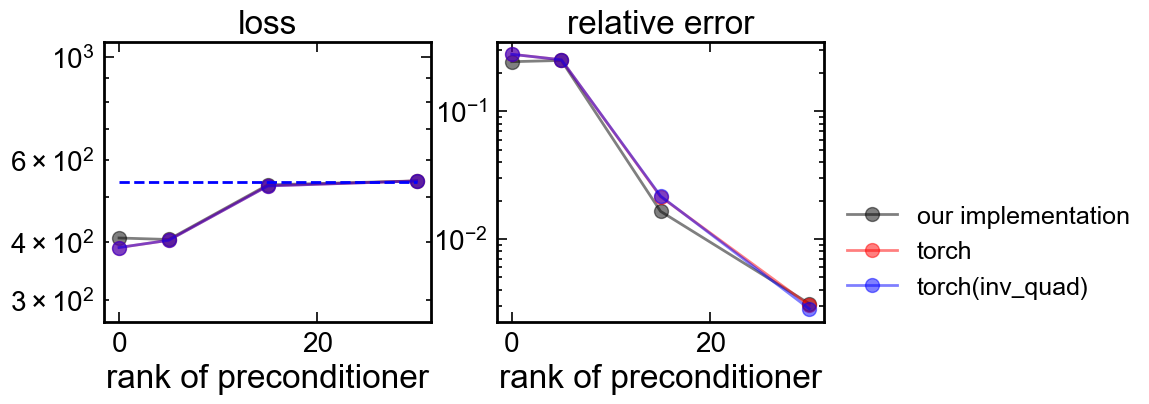

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
ax = axs[0]
ax.semilogy(rank_list, loss_ours_list, marker='o', alpha=0.5, label='our implementation', color='black')
ax.semilogy(rank_list, loss_torch_list, marker='o', alpha=0.5, label='torch', color='r')
ax.semilogy(rank_list, loss_torch_inv_quad_list, marker='o', alpha=0.5, label='torch(inv_quad)', color='b')
ax.hlines(loss_ans_linalg, min(rank_list), max(rank_list), color='b', label='answer', linestyle='--')
ax.set_xlabel('rank of preconditioner')
ax.set_title("loss")
ax.set_ylim(loss_ans_linalg * 5e-1, loss_ans_linalg * 2)
ax = axs[1]
ax.semilogy(rank_list, rel_ours_list, marker='o', alpha=0.5, label='our implementation', color='black')
ax.semilogy(rank_list, rel_torch_list, marker='o', alpha=0.5, label='torch', color='r')
ax.semilogy(rank_list, rel_torch_inv_quad_list, marker='o', alpha=0.5, label='torch(inv_quad)', color='b')
ax.set_xlabel('rank of preconditioner')
ax.set_title('relative error')
plt.legend(bbox_to_anchor=(1, 0), loc='lower left')

In [12]:
rank_list = [0, 5, 15, 30]
rel_yKy_ours_list = []
rel_yKy_torch_list = []
rel_yKy_torch_inv_quad_list = []
rel_logdet_ours_list = []
rel_logdet_torch_list = []
rel_logdet_torch_inv_quad_list = []
min_preconditioning_size = 10000
linear_operator.settings.min_preconditioning_size._set_value(
    min_preconditioning_size
)
warnings.filterwarnings("ignore")
for rank in rank_list:
    linear_operator.settings.max_preconditioner_size._set_value(rank)
    Kinvy_ours, logdet_ours = loss_mpcg(_K, delta_y, n_tridiag, seed=0, rank=rank, cg_tolerance=cg_tolerance, max_tridiag_iter=max_tridiag_iter, max_cg_iterations=max_cg_iterations, min_preconditioning_size=min_preconditioning_size, return_linear_solve=True, return_logdet=True, return_loss=False)
    
    Kinvy_torch, logdet_torch = loss_torch(_K, delta_y, n_tridiag, return_linear_solve=True, return_logdet=True, return_loss=False)
    yKinvy_torch_inv_quad, logdet_torch_inv_quad = loss_torch_inv_quad(_K, delta_y, n_tridiag, return_linear_solve=True, return_logdet=True, return_loss=False)

    rel_yKy_ours_list.append(test_modules.rel_error_scaler(delta_y@Kinvy_linalg, delta_y@Kinvy_ours[:, -1]))
    rel_yKy_torch_list.append(test_modules.rel_error_scaler(delta_y@Kinvy_linalg, delta_y@Kinvy_torch.numpy()[:, -1]))
    rel_yKy_torch_inv_quad_list.append(test_modules.rel_error_scaler(delta_y@Kinvy_linalg, yKinvy_torch_inv_quad))

    rel_logdet_ours_list.append(test_modules.rel_error_scaler(logdet_linalg, logdet_ours))
    rel_logdet_torch_list.append(test_modules.rel_error_scaler(logdet_linalg, logdet_torch.numpy()))
    rel_logdet_torch_inv_quad_list.append(test_modules.rel_error_scaler(logdet_linalg, logdet_torch_inv_quad))
    if rank == 0:
        min_preconditioning_size = 1
        linear_operator.settings.min_preconditioning_size._set_value(
            min_preconditioning_size
        )
warnings.filterwarnings("always")

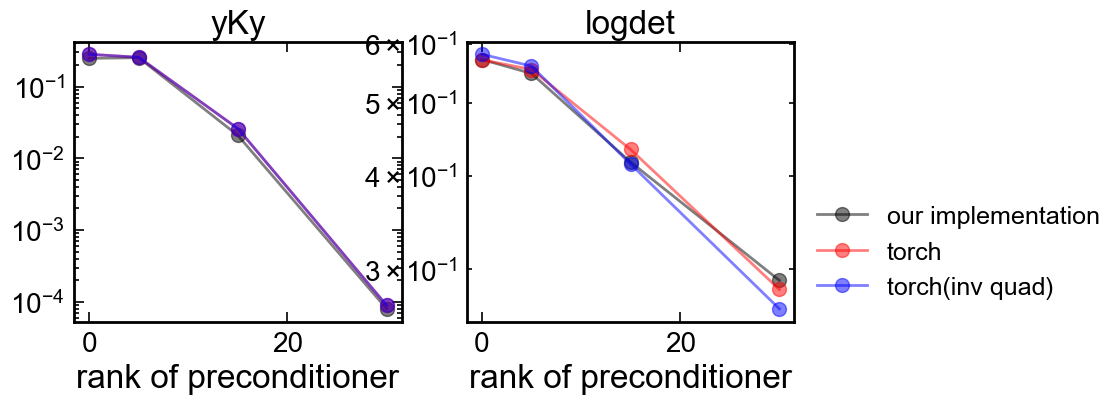

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
ax = axs[0]
ax.semilogy(rank_list, rel_yKy_ours_list, marker='o', alpha=0.5, label='our implementation', color='black')
ax.semilogy(rank_list, rel_yKy_torch_list, marker='o', alpha=0.5, label='torch', color='r')
ax.semilogy(rank_list, rel_yKy_torch_inv_quad_list, marker='o', alpha=0.5, label='torch(inv quad)', color='b')
ax.set_xlabel('rank of preconditioner')
ax.set_title("yKy")
ax = axs[1]
ax.semilogy(rank_list, rel_logdet_ours_list, marker='o', alpha=0.5, label='our implementation', color='black')
ax.semilogy(rank_list, rel_logdet_torch_list, marker='o', alpha=0.5, label='torch', color='r')
ax.semilogy(rank_list, rel_logdet_torch_inv_quad_list, marker='o', alpha=0.5, label='torch(inv quad)', color='b')
ax.set_xlabel('rank of preconditioner')
ax.set_title('logdet')
plt.legend(bbox_to_anchor=(1, 0), loc='lower left')

## kerenl with optimized hyper-parameter

In [14]:
_K = np.load("tests/data/cov_sinusoidal_direct_opt.npy")
delta_y = np.load("tests/data/delta_y_sinusoidal_direct.npy")
seed=0
noise=1e-06
N = len(_K)
K = _K + jnp.eye(N) * noise
test_modules.check_cond(K)

3.42e+10


DeviceArray(3.41619154e+10, dtype=float64)

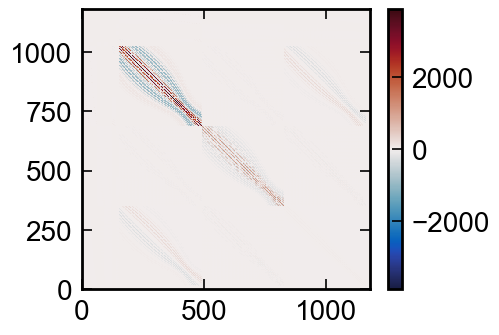

In [15]:
fig, ax = plt.subplots(figsize=(5, 4))
mappable = ax.pcolormesh(np.flipud(K), vmin=-np.max(K), vmax=np.max(K), cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [16]:
test_modules.check_cholesky_inverse_accuracy(K)

1.0000000030460905


In [17]:
rank = 15
n_tridiag = 10
max_cg_iterations = 1000
max_tridiag_iter = 20
cg_tolerance = 0.01
min_preconditioning_size=1

linear_operator.settings.cg_tolerance._set_value(cg_tolerance)
linear_operator.settings.min_preconditioning_size._set_value(
    min_preconditioning_size
)
linear_operator.settings.max_cg_iterations._set_value(max_cg_iterations)
linear_operator.settings.num_trace_samples._set_value(n_tridiag)
linear_operator.settings.max_lanczos_quadrature_iterations._set_value(
    max_tridiag_iter
)
linear_operator.settings.max_preconditioner_size._set_value(rank)

In [18]:
loss_ans_linalg, Kinvy_linalg, logdet_linalg = loss_linalg(K, delta_y, return_linear_solve=True, return_logdet=True, return_loss=True)

In [19]:
loss_ans_linalg, Kinvy_linalg, logdet_linalg

(DeviceArray(-1.10776875, dtype=float64),
 DeviceArray([ -12.94305997, -123.28387622,   77.01065309, ...,
              -207.63199945,  209.51658106,  -76.5709731 ], dtype=float64),
 DeviceArray(-5875.16389999, dtype=float64))

In [20]:
delta_y@Kinvy_linalg

DeviceArray(1092.13470931, dtype=float64)

In [21]:
rank_list = [0, 5, 15, 30]
loss_ours_list = []
loss_torch_list = []
rel_ours_list = []
rel_torch_list = []
rel_torch_inv_quad_list = []
loss_torch_inv_quad_list = []
min_preconditioning_size = 10000
linear_operator.settings.min_preconditioning_size._set_value(
    min_preconditioning_size
)
warnings.filterwarnings("ignore")
for rank in rank_list:
    linear_operator.settings.max_preconditioner_size._set_value(rank)
    loss_ours_list.append(loss_mpcg(_K, delta_y, n_tridiag, seed=0, rank=rank, cg_tolerance=cg_tolerance, max_tridiag_iter=max_tridiag_iter, max_cg_iterations=max_cg_iterations, min_preconditioning_size=min_preconditioning_size)[0])
    
    loss_torch_list.append(loss_torch(_K, delta_y, n_tridiag)[0])
    loss_torch_inv_quad_list.append(loss_torch_inv_quad(_K, delta_y, n_tridiag)[0])

    rel_ours_list.append(test_modules.rel_error_scaler(loss_ans_linalg, loss_ours_list[-1]))
    rel_torch_list.append(test_modules.rel_error_scaler(loss_ans_linalg, loss_torch_list[-1]))
    rel_torch_inv_quad_list.append(test_modules.rel_error_scaler(loss_ans_linalg, loss_torch_inv_quad_list[-1]))
    if rank == 0:
        min_preconditioning_size = 1
        linear_operator.settings.min_preconditioning_size._set_value(
            min_preconditioning_size
        )
warnings.filterwarnings("always")

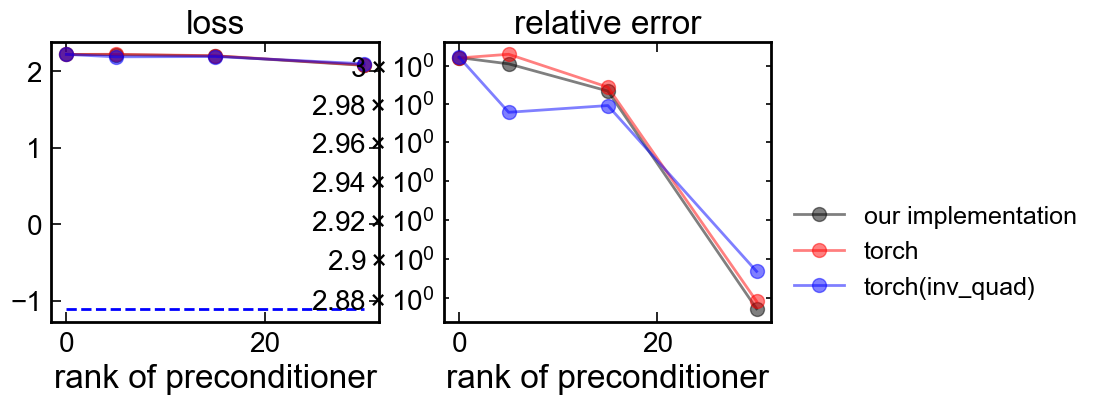

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
ax = axs[0]
ax.plot(rank_list, loss_ours_list, marker='o', alpha=0.5, label='our implementation', color='black')
ax.plot(rank_list, loss_torch_list, marker='o', alpha=0.5, label='torch', color='r')
ax.plot(rank_list, loss_torch_inv_quad_list, marker='o', alpha=0.5, label='torch(inv_quad)', color='b')
ax.hlines(loss_ans_linalg, min(rank_list), max(rank_list), color='b', label='answer', linestyle='--')
ax.set_xlabel('rank of preconditioner')
ax.set_title("loss")
# ax.set_ylim(loss_ans_linalg * 5e-1, loss_ans_linalg * 2)
ax = axs[1]
ax.semilogy(rank_list, rel_ours_list, marker='o', alpha=0.5, label='our implementation', color='black')
ax.semilogy(rank_list, rel_torch_list, marker='o', alpha=0.5, label='torch', color='r')
ax.semilogy(rank_list, rel_torch_inv_quad_list, marker='o', alpha=0.5, label='torch(inv_quad)', color='b')
ax.set_xlabel('rank of preconditioner')
ax.set_title('relative error')
plt.legend(bbox_to_anchor=(1, 0), loc='lower left')

In [23]:
rank_list = [0, 5, 15, 30]
rel_yKy_ours_list = []
rel_yKy_torch_list = []
rel_yKy_torch_inv_quad_list = []
rel_logdet_ours_list = []
rel_logdet_torch_list = []
rel_logdet_torch_inv_quad_list = []
min_preconditioning_size = 10000
linear_operator.settings.min_preconditioning_size._set_value(
    min_preconditioning_size
)
warnings.filterwarnings("ignore")
for rank in rank_list:
    linear_operator.settings.max_preconditioner_size._set_value(rank)
    Kinvy_ours, logdet_ours = loss_mpcg(_K, delta_y, n_tridiag, seed=0, rank=rank, cg_tolerance=cg_tolerance, max_tridiag_iter=max_tridiag_iter, max_cg_iterations=max_cg_iterations, min_preconditioning_size=min_preconditioning_size, return_linear_solve=True, return_logdet=True, return_loss=False)
    
    Kinvy_torch, logdet_torch = loss_torch(_K, delta_y, n_tridiag, return_linear_solve=True, return_logdet=True, return_loss=False)
    yKinvy_torch_inv_quad, logdet_torch_inv_quad = loss_torch_inv_quad(_K, delta_y, n_tridiag, return_linear_solve=True, return_logdet=True, return_loss=False)

    rel_yKy_ours_list.append(test_modules.rel_error_scaler(delta_y@Kinvy_linalg, delta_y@Kinvy_ours[:, -1]))
    rel_yKy_torch_list.append(test_modules.rel_error_scaler(delta_y@Kinvy_linalg, delta_y@Kinvy_torch.numpy()[:, -1]))
    rel_yKy_torch_inv_quad_list.append(test_modules.rel_error_scaler(delta_y@Kinvy_linalg, yKinvy_torch_inv_quad))

    rel_logdet_ours_list.append(test_modules.rel_error_scaler(logdet_linalg, logdet_ours))
    rel_logdet_torch_list.append(test_modules.rel_error_scaler(logdet_linalg, logdet_torch.numpy()))
    rel_logdet_torch_inv_quad_list.append(test_modules.rel_error_scaler(logdet_linalg, logdet_torch_inv_quad))
    if rank == 0:
        min_preconditioning_size = 1
        linear_operator.settings.min_preconditioning_size._set_value(
            min_preconditioning_size
        )
warnings.filterwarnings("always")

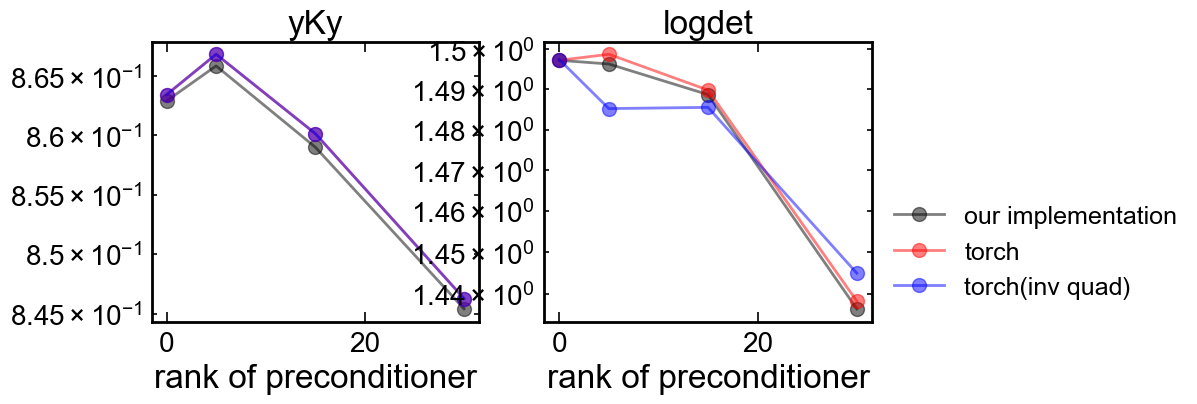

In [24]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
ax = axs[0]
ax.semilogy(rank_list, rel_yKy_ours_list, marker='o', alpha=0.5, label='our implementation', color='black')
ax.semilogy(rank_list, rel_yKy_torch_list, marker='o', alpha=0.5, label='torch', color='r')
ax.semilogy(rank_list, rel_yKy_torch_inv_quad_list, marker='o', alpha=0.5, label='torch(inv quad)', color='b')
ax.set_xlabel('rank of preconditioner')
ax.set_title("yKy")
# ax.set_ylim(0.01, 1)
ax = axs[1]
ax.semilogy(rank_list, rel_logdet_ours_list, marker='o', alpha=0.5, label='our implementation', color='black')
ax.semilogy(rank_list, rel_logdet_torch_list, marker='o', alpha=0.5, label='torch', color='r')
ax.semilogy(rank_list, rel_logdet_torch_inv_quad_list, marker='o', alpha=0.5, label='torch(inv quad)', color='b')
ax.set_xlabel('rank of preconditioner')
ax.set_title('logdet')
plt.legend(bbox_to_anchor=(1, 0), loc='lower left')

### check randomness

In [23]:
rank = 15
seed_list = np.arange(5)
rel_yKy_ours_list = []
rel_yKy_torch_list = []
rel_yKy_torch_inv_quad_list = []
rel_logdet_ours_list = []
rel_logdet_torch_list = []
rel_logdet_torch_inv_quad_list = []
warnings.filterwarnings("ignore")
for seed in seed_list:
    linear_operator.settings.max_preconditioner_size._set_value(rank)
    Kinvy_ours, logdet_ours = loss_mpcg(_K, delta_y, n_tridiag, seed=seed, rank=rank, cg_tolerance=cg_tolerance, max_tridiag_iter=max_tridiag_iter, max_cg_iterations=max_cg_iterations, min_preconditioning_size=min_preconditioning_size, return_linear_solve=True, return_logdet=True, return_loss=False)
    
    Kinvy_torch, logdet_torch = loss_torch(_K, delta_y, n_tridiag, return_linear_solve=True, return_logdet=True, return_loss=False, seed=seed)
    yKinvy_torch_inv_quad, logdet_torch_inv_quad = loss_torch_inv_quad(_K, delta_y, n_tridiag, return_linear_solve=True, return_logdet=True, return_loss=False, seed=seed)

    rel_yKy_ours_list.append(test_modules.rel_error_scaler(delta_y@Kinvy_linalg, delta_y@Kinvy_ours[:, -1]))
    rel_yKy_torch_list.append(test_modules.rel_error_scaler(delta_y@Kinvy_linalg, delta_y@Kinvy_torch.numpy()[:, -1]))
    rel_yKy_torch_inv_quad_list.append(test_modules.rel_error_scaler(delta_y@Kinvy_linalg, yKinvy_torch_inv_quad))

    rel_logdet_ours_list.append(test_modules.rel_error_scaler(logdet_linalg, logdet_ours))
    rel_logdet_torch_list.append(test_modules.rel_error_scaler(logdet_linalg, logdet_torch.numpy()))
    rel_logdet_torch_inv_quad_list.append(test_modules.rel_error_scaler(logdet_linalg, logdet_torch_inv_quad))
warnings.filterwarnings("always")

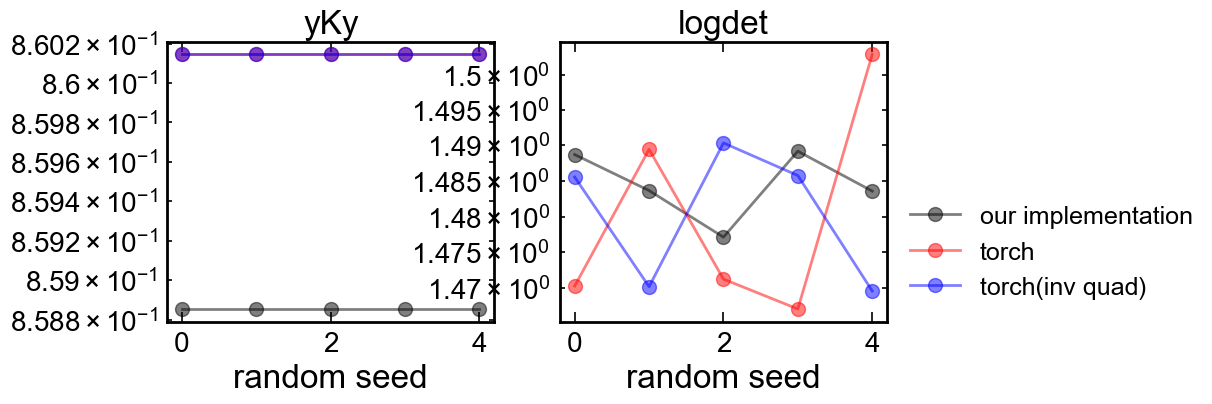

In [24]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
ax = axs[0]
ax.semilogy(seed_list, rel_yKy_ours_list, marker='o', alpha=0.5, label='our implementation', color='black')
ax.semilogy(seed_list, rel_yKy_torch_list, marker='o', alpha=0.5, label='torch', color='r')
ax.semilogy(seed_list, rel_yKy_torch_inv_quad_list, marker='o', alpha=0.5, label='torch(inv quad)', color='b')
ax.set_xlabel('random seed')
ax.set_title("yKy")
# ax.set_ylim(0.01, 1)
ax = axs[1]
ax.semilogy(seed_list, rel_logdet_ours_list, marker='o', alpha=0.5, label='our implementation', color='black')
ax.semilogy(seed_list, rel_logdet_torch_list, marker='o', alpha=0.5, label='torch', color='r')
ax.semilogy(seed_list, rel_logdet_torch_inv_quad_list, marker='o', alpha=0.5, label='torch(inv quad)', color='b')
ax.set_xlabel('random seed')
ax.set_title('logdet')
plt.legend(bbox_to_anchor=(1, 0), loc='lower left')